## Initializing Stuff 

In [1]:
import numpy as np
import pandas as pd
import gymnasium as gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical, Normal

from tqdm import tqdm
from itertools import count

## Define the Actor and the  Critic Network

In [2]:
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_actions)

    def forward(self, state):
        state = state.unsqueeze(0)
        policy_dist = F.relu(self.fc1(state))
        policy_dist = self.fc2(policy_dist)
        return policy_dist

    def act(self, state):
        state = state.unsqueeze(0)
        policy_logits = self(state)
        m = Categorical(logits=policy_logits)
        action = m.sample()
        return action.item(), m.log_prob(action)

class Critic(nn.Module):
    def __init__(self, num_inputs, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, state):
        state = state.unsqueeze(0)
        value = F.relu(self.fc1(state))
        value = self.fc2(value)
        return value


## Define the A2C Trainer

In [3]:
def train_actor_critic(
    env: gym.Env,
    actor_net: Actor,
    critic_net: Critic,
    optimizer: optim.Optimizer,
    num_episodes: int = int(1e4),
    disc_factor: float = .99,
    report_every_n_episodes: int = 30,
    quiet: bool = False,
    cuda: bool = False,
    early_stopping_rwd: float = float('inf'),
    early_stopping_window: int = 20
):
    device = torch.device('cuda' if cuda else 'cpu')
    actor_net.to(device)
    critic_net.to(device)

    sheduler_args = {
        'milestones': [int(num_episodes/3), int(3*num_episodes/4)],
        'gamma': .5
    }
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, **sheduler_args)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    average_rewards = []

    prog_bar = tqdm(range(num_episodes), desc='Training Episode', disable=quiet)
    for episode in prog_bar:
        log_probs = []
        values = []
        rewards = []

        state, _ = env.reset()
        state = torch.tensor(state).float().to(device)
        for steps in count():
            value = critic_net(state)
            action, log_prob = actor_net.act(state)

            new_state, reward, terminated, truncated, _ = env.step(action)
            new_state = torch.tensor(new_state).float().to(device)

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            state = new_state
            
            if terminated or truncated:
                # Aggregating
                rewards = torch.FloatTensor(rewards)
                values = torch.stack(values).squeeze()
                log_probs = torch.stack(log_probs).squeeze()

                all_rewards.append(rewards.sum().item())
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-report_every_n_episodes:]))
                average_rewards.append(np.mean(all_rewards[-report_every_n_episodes:]))
                if episode % report_every_n_episodes == 0:
                    prog_bar.set_postfix_str(
                        f"reward: {all_rewards[-1]}, len: {steps}, "\
                        f"{report_every_n_episodes}-episode average reward: {average_rewards[-1]}, "\
                        f"{report_every_n_episodes}-episode average len: {average_lengths[-1]}"
                    )
                break

        # Value of the last state is always 0 when truncated
        value_t_p_1 = 0 if terminated else critic_net(new_state)
        # Compute Q values for all the states in the trajectory
        q_values = torch.zeros_like(values)
        for t in reversed(range(len(rewards))):
            q_value = rewards[t] + disc_factor * value_t_p_1
            q_values[t] = q_value
            # The value for time step t+1
            value_t_p_1 = values[t]

        # Policy Gradient
        advantage = q_values - values
        actor_loss = (-log_probs * advantage.detach()).mean()

        # Critic loss
        criterion = nn.SmoothL1Loss()
        critic_loss = criterion(values, q_values)
        ac_loss = actor_loss + critic_loss

        optimizer.zero_grad()
        ac_loss.backward()
        # # In-place gradient clipping to prevent exploding gradients.
        # torch.nn.utils.clip_grad_value_(actor_net.parameters(), 10)
        # torch.nn.utils.clip_grad_value_(critic_net.parameters(), 10)
        optimizer.step()

        # Stop training if the last `early_stopping_window` reward
        # running averages are above `early_stopping_rwd`
        if all([rwd > early_stopping_rwd
                for rwd in average_rewards[-early_stopping_window:]]):
            break

        scheduler.step()

    return average_lengths, average_rewards


### Agent Evaluation

In [4]:
def eval_actor_critic(
    env: gym.Env,
    actor_net: Actor,
    num_episodes: int = 200,
    quiet: bool = False,
    cuda: bool = False,
    report_every_n_episodes: int = 20
):
    device = torch.device('cuda' if cuda else 'cpu')
    actor_net.to(device)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    average_rewards = []

    prog_bar = tqdm(range(num_episodes), desc='Evaluation Episode', disable=quiet)
    for episode in prog_bar:
        rewards = []

        state, _ = env.reset()
        state = torch.tensor(state).float().to(device)
        for steps in count():
            with torch.no_grad():
                action, _ = actor_net.act(state)

                new_state, reward, terminated, truncated, _ = env.step(action)
                new_state = torch.tensor(new_state).float().to(device)

                rewards.append(reward)
                state = new_state

            if terminated or truncated:
                # Aggregating
                rewards = torch.FloatTensor(rewards)

                all_rewards.append(rewards.sum().item())
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-report_every_n_episodes:]))
                average_rewards.append(np.mean(all_rewards[-report_every_n_episodes:]))
                if episode % report_every_n_episodes == 0:
                    prog_bar.set_postfix_str(
                        f"reward: {all_rewards[-1]}, len: {steps}, "\
                        f"{report_every_n_episodes}-episode average reward: {average_rewards[-1]}, "\
                        f"{report_every_n_episodes}-episode average len: {average_lengths[-1]}"
                    )
                break

    return average_lengths, average_rewards
            

### Agent Visualization

In [5]:
import matplotlib.pyplot as plt


def plot_metrics(tr_metric, eval_metric, tr_metric_name, eval_metric_name):
    plt.rcParams["figure.figsize"] = (60,28)
    plt.rcParams["font.size"] = 44
    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.set_xlabel('Training Episodes')
    ax1.set_ylabel(tr_metric_name)
    ax1.plot(tr_metric, linewidth=6, color='#0077b6')
    ax1.grid(True)

    ax2.set_xlabel('Eval Episodes')
    ax2.set_ylabel(eval_metric_name)
    ax2.plot(eval_metric, linewidth=6, color='#50c878')
    ax2.grid(True)

    plt.show()


## CartPole-v1

### Definitions A2C

In [6]:
# Hyperparams
hidden_size = 32
learning_rate = 5e-3

cartenv = gym.make('CartPole-v1')

num_inputs = cartenv.observation_space.shape[0]
num_outputs = cartenv.action_space.n

actor = Actor(num_inputs, num_outputs, hidden_size)
critic = Critic(num_inputs, hidden_size)

params = list(actor.parameters()) + list(critic.parameters())
optimizer = optim.AdamW(params, lr=learning_rate)

### Train the agent

In [7]:
avg_len, avg_rwd = train_actor_critic(
    cartenv, actor, critic,
    optimizer, num_episodes=2**13,
    early_stopping_rwd=470, cuda=True
)

Training Episode:  18%|█▊        | 1491/8192 [09:16<41:41,  2.68it/s, reward: 500.0, len: 499, 30-episode average reward: 460.43333333333334, 30-episode average len: 459.43333333333334]  


### Evaluate the agent

In [8]:
eval_avg_len, eval_avg_rwd = eval_actor_critic(cartenv, actor)

Evaluation Episode: 100%|██████████| 200/200 [00:40<00:00,  4.99it/s, reward: 424.0, len: 423, 20-episode average reward: 485.3, 20-episode average len: 484.3]  


In [9]:
# torch.save(actor.state_dict(),'m44_saileshr_assignment3_a2c_actor_cartpolev1.pth')
# torch.save(critic.state_dict(),'m44_saileshr_assignment3_a2c_critic_cartpolev1.pth')

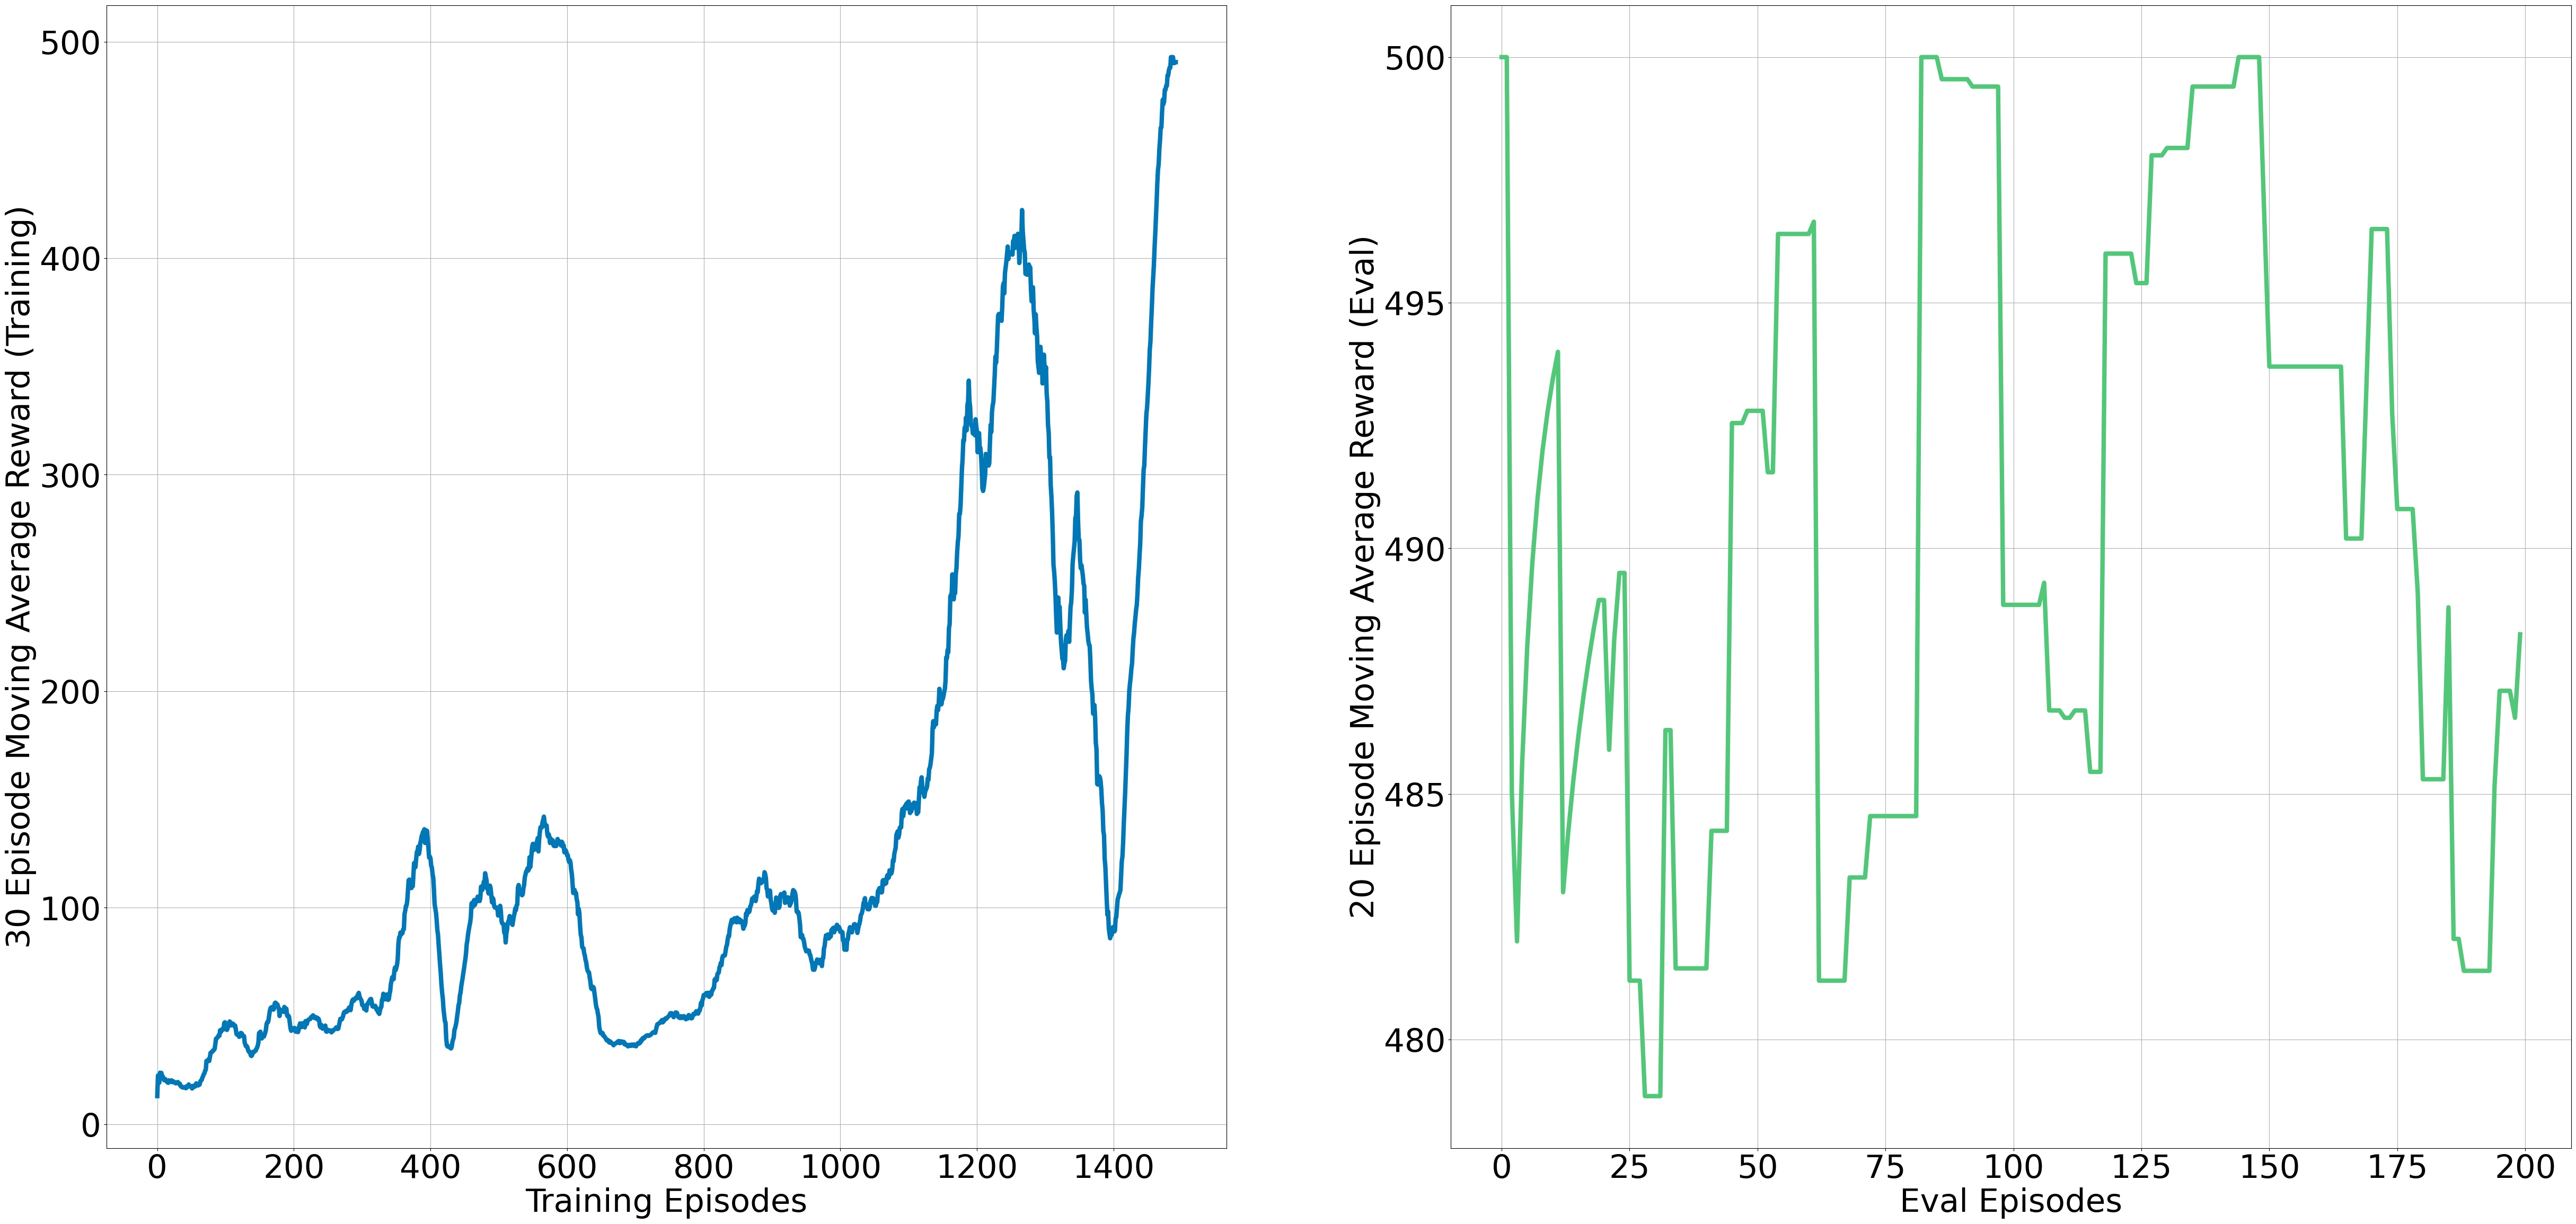

In [10]:
plot_metrics(avg_rwd, eval_avg_rwd, "30 Episode Moving Average Reward (Training)", "20 Episode Moving Average Reward (Eval)")

## LunarLander-v2

### Definitions A2C

In [68]:
# Hyperparams
hidden_size = 128
learning_rate = 5e-3

lunarenv = gym.make("LunarLander-v2")

num_inputs = lunarenv.observation_space.shape[0]
num_outputs = lunarenv.action_space.n

actor = Actor(num_inputs, num_outputs, hidden_size)
critic = Critic(num_inputs, hidden_size)

params = list(actor.parameters()) + list(critic.parameters())
optimizer = optim.AdamW(params, lr=learning_rate)

### Train the agent

In [69]:
avg_len, avg_rwd = train_actor_critic(
    lunarenv, actor, critic,
    optimizer, num_episodes=2**13,
    early_stopping_rwd=190
)

Training Episode:  54%|█████▍    | 4446/8192 [21:15<17:54,  3.49it/s, reward: 246.72486877441406, len: 308, 30-episode average reward: 205.33477528889975, 30-episode average len: 467.3666666666667]    


### Evaluate the agent

In [64]:
eval_avg_len, eval_avg_rwd = eval_actor_critic(lunarenv, actor)

Evaluation Episode: 100%|██████████| 200/200 [00:22<00:00,  8.84it/s, reward: 278.38128662109375, len: 249, 20-episode average reward: 179.43394689559938, 20-episode average len: 180.0]


In [67]:
# torch.save(actor,'m44_saileshr_assignment3_a2c_actor_lunarlander.pth')
# torch.save(critic,'m44_saileshr_assignment3_a2c_critic_lunarlander.pth')

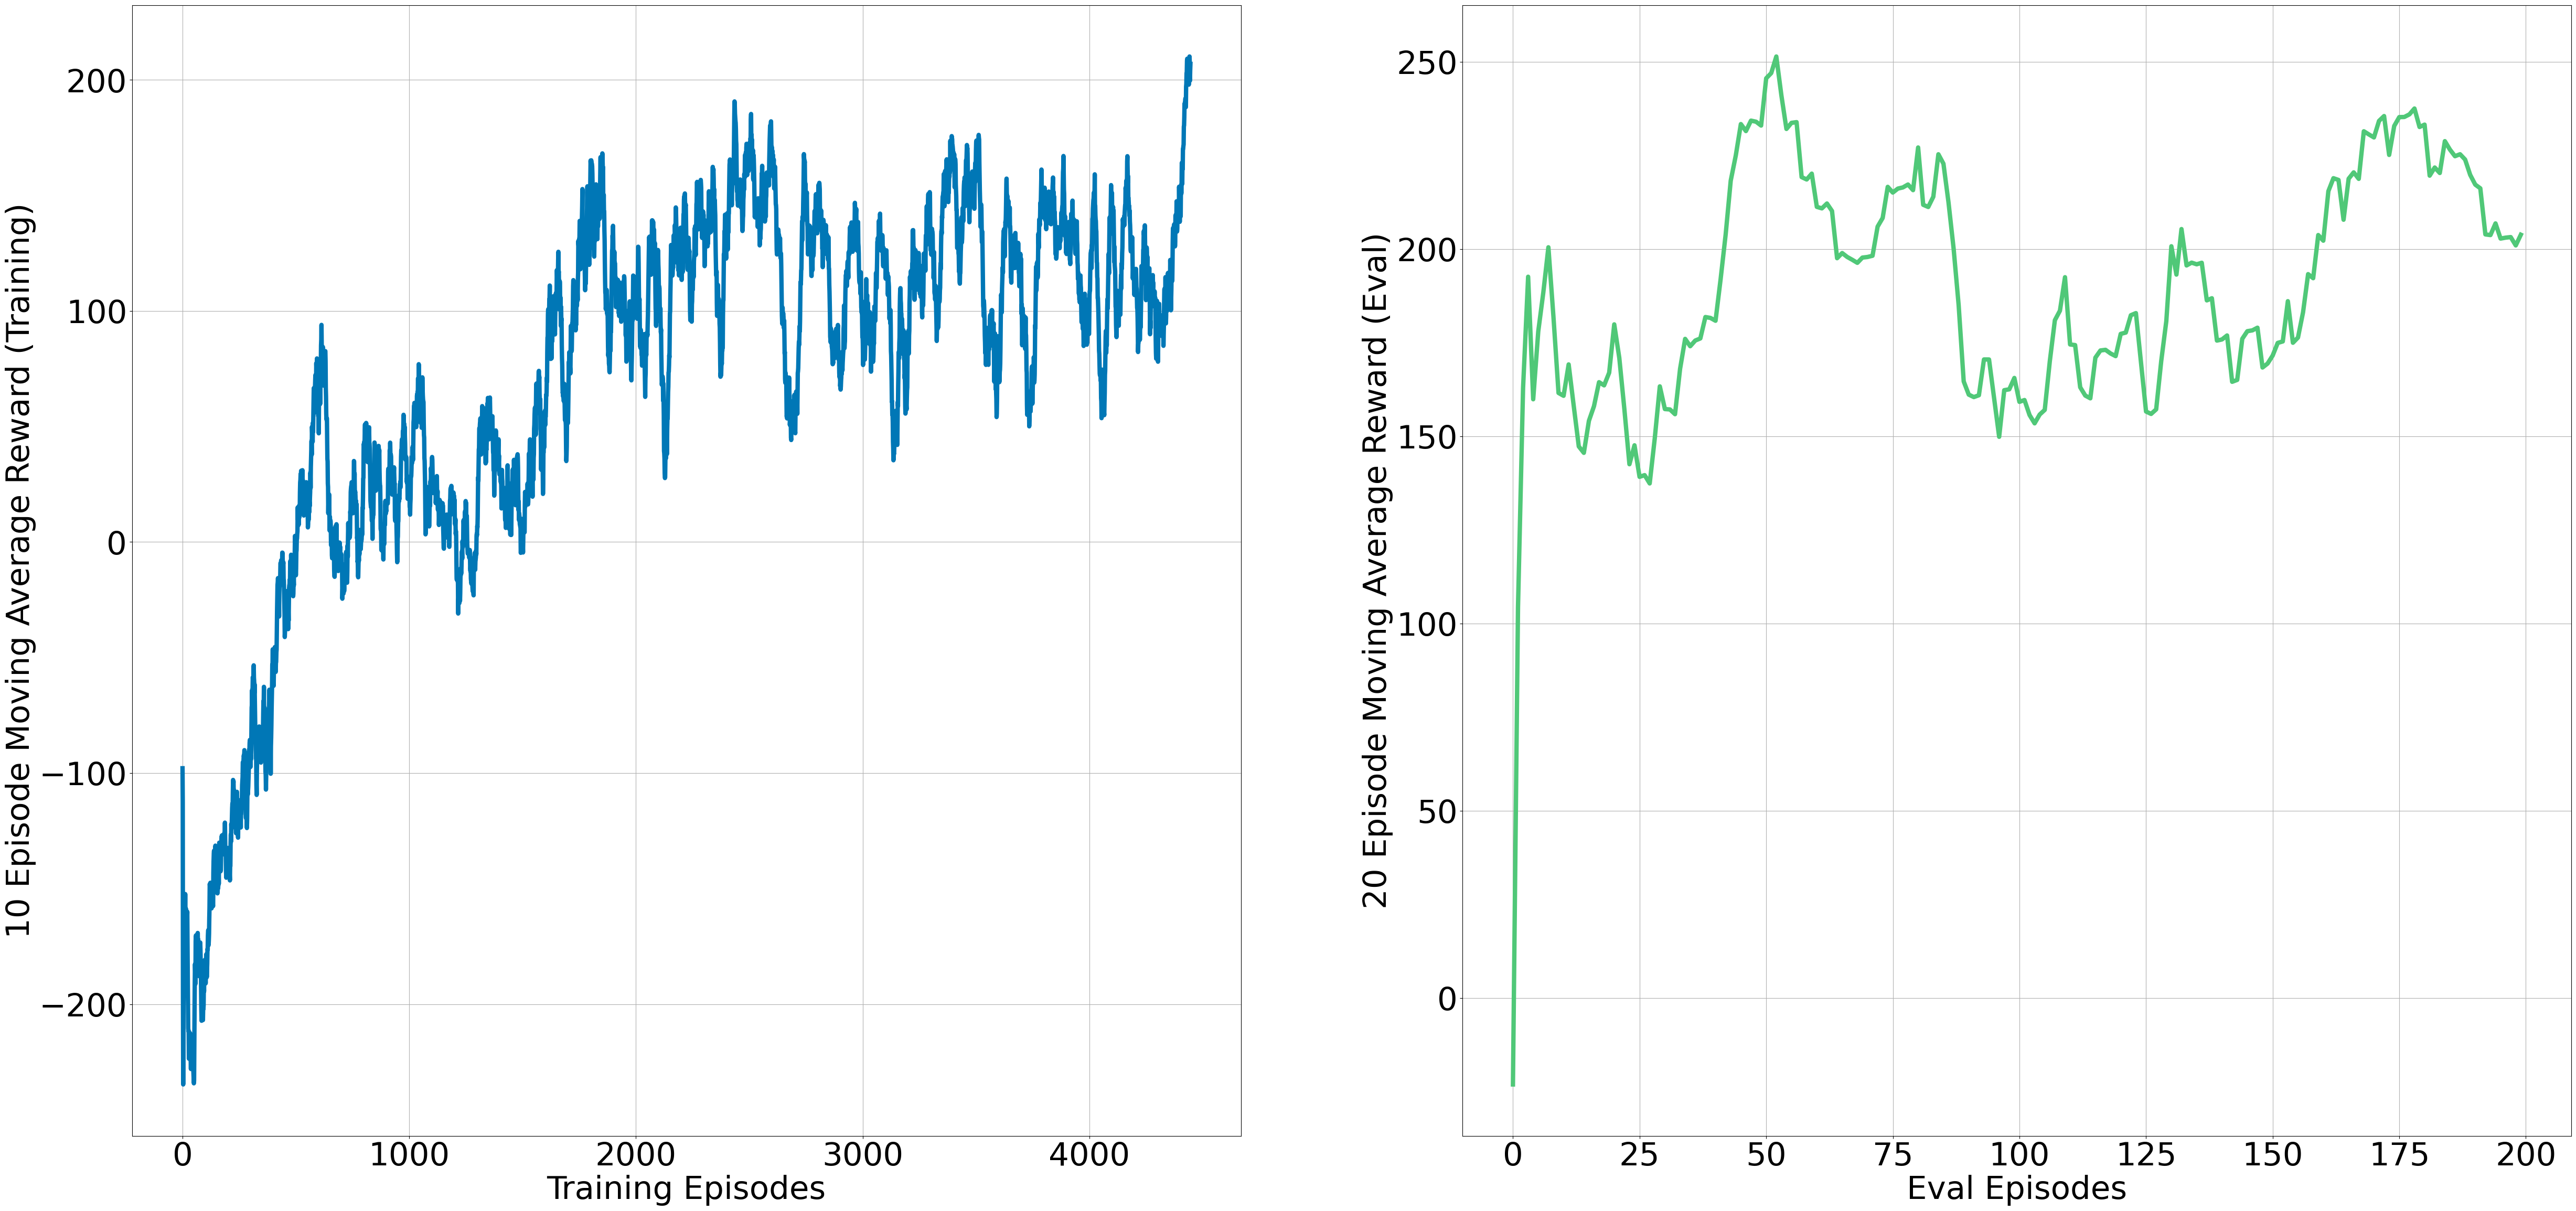

In [70]:
plot_metrics(avg_rwd, eval_avg_rwd, "10 Episode Moving Average Reward (Training)", "20 Episode Moving Average Reward (Eval)")

## Continuous Environment

In [59]:
class ContinuousActor(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, action_scaler: float = 1.):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, hidden_size)
        self.fc2 = nn.Linear(hidden_size, int(hidden_size/2))
        self.mu_net = nn.Linear(int(hidden_size/2), num_actions)
        self.sigma_net = nn.Linear(int(hidden_size/2), num_actions)

        self.scaler = action_scaler
        self.eps = 1e-8 # For numerical stability

    def forward(self, state):
        state = state.unsqueeze(0)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.scaler * F.tanh(self.mu_net(x))
        sigma = F.softplus(self.sigma_net(x)) # ReLU to ensure positive values 
        return mu, sigma

    def act(self, state):
        mu, sigma = self(state)
        m = Normal(mu.squeeze()+self.eps, sigma.squeeze()+self.eps)
        action = m.sample()
        return action, m.log_prob(action)

### Define continous A2C Trainer

In [7]:
def train_cont_actor_critic(
    env: gym.Env,
    actor_net: Actor,
    critic_net: Critic,
    optimizer: optim.Optimizer,
    num_episodes: int = int(1e4),
    disc_factor: float = .99,
    report_every_n_episodes: int = 30,
    quiet: bool = False,
    cuda: bool = False,
    early_stopping_rwd: float = float('inf'),
    early_stopping_window: int = 20
):
    device = torch.device('cuda' if cuda else 'cpu')
    actor_net.to(device)
    critic_net.to(device)

    sheduler_args = {
        'milestones': [int(num_episodes/3), int(3*num_episodes/4)],
        'gamma': .5
    }
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, **sheduler_args)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    average_rewards = []

    prog_bar = tqdm(range(num_episodes), desc='Training Episode', disable=quiet)
    for episode in prog_bar:
        log_probs = []
        values = []
        rewards = []

        state, _ = env.reset()
        state = torch.tensor(state).float().to(device)
        for steps in count():
            value = critic_net(state)
            action, log_prob = actor_net.act(state)

            new_state, reward, terminated, truncated, _ = env.step([action.item()])
            new_state = torch.tensor(new_state).float().to(device)

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            state = new_state
            
            if terminated or truncated:
                # Aggregating
                rewards = torch.FloatTensor(rewards)
                values = torch.stack(values).squeeze()
                log_probs = torch.stack(log_probs).squeeze()

                all_rewards.append(rewards.sum().item())
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-report_every_n_episodes:]))
                average_rewards.append(np.mean(all_rewards[-report_every_n_episodes:]))
                if episode % report_every_n_episodes == 0:
                    prog_bar.set_postfix_str(
                        f"reward: {all_rewards[-1]}, len: {steps}, "\
                        f"{report_every_n_episodes}-episode average reward: {average_rewards[-1]}, "\
                        f"{report_every_n_episodes}-episode average len: {average_lengths[-1]}"
                    )
                break

        # Value of the last state is always 0 when truncated
        value_t_p_1 = 0 if terminated else critic_net(new_state)
        # Compute Q values for all the states in the trajectory
        q_values = torch.zeros_like(values)
        for t in reversed(range(len(rewards))):
            q_value = rewards[t] + disc_factor * value_t_p_1
            q_values[t] = q_value
            # The value for time step t+1
            value_t_p_1 = values[t]

        # Policy Gradient
        advantage = q_values - values
        actor_loss = (-log_probs * advantage.detach()).mean()

        # Critic loss
        criterion = nn.SmoothL1Loss()
        critic_loss = criterion(values, q_values)
        ac_loss = actor_loss + critic_loss

        optimizer.zero_grad()
        ac_loss.backward()
        # # In-place gradient clipping to prevent exploding gradients.
        # torch.nn.utils.clip_grad_value_(actor_net.parameters(), 10)
        # torch.nn.utils.clip_grad_value_(critic_net.parameters(), 10)
        optimizer.step()

        # Stop training if the last `early_stopping_window` reward
        # running averages are above `early_stopping_rwd`
        if all([rwd > early_stopping_rwd
                for rwd in average_rewards[-early_stopping_window:]]):
            break

        scheduler.step()

    return average_lengths, average_rewards


### Define continuous A2C Evaluation

In [8]:
def eval_cont_actor_critic(
    env: gym.Env,
    actor_net: Actor,
    num_episodes: int = 200,
    quiet: bool = False,
    cuda: bool = False,
    report_every_n_episodes: int = 20
):
    device = torch.device('cuda' if cuda else 'cpu')
    actor_net.to(device)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    average_rewards = []

    prog_bar = tqdm(range(num_episodes), desc='Evaluation Episode', disable=quiet)
    for episode in prog_bar:
        rewards = []

        state, _ = env.reset()
        state = torch.tensor(state).float().to(device)
        for steps in count():
            with torch.no_grad():
                action, _ = actor_net.act(state)

                new_state, reward, terminated, truncated, _ = env.step([action.item()])
                new_state = torch.tensor(new_state).float().to(device)

                rewards.append(reward)
                state = new_state

            if terminated or truncated:
                # Aggregating
                rewards = torch.FloatTensor(rewards)

                all_rewards.append(rewards.sum().item())
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-report_every_n_episodes:]))
                average_rewards.append(np.mean(all_rewards[-report_every_n_episodes:]))
                if episode % report_every_n_episodes == 0:
                    prog_bar.set_postfix_str(
                        f"reward: {all_rewards[-1]}, len: {steps}, "\
                        f"{report_every_n_episodes}-episode average reward: {average_rewards[-1]}, "\
                        f"{report_every_n_episodes}-episode average len: {average_lengths[-1]}"
                    )
                break

    return average_lengths, average_rewards

## InvertedPendulum-v4

### Definitions A2C

In [9]:
# Hyperparams
hidden_size = 64
learning_rate = 5e-3

pendulumenv = gym.make('InvertedPendulum-v4')

num_inputs = pendulumenv.observation_space.shape[0]
num_outputs = pendulumenv.action_space.shape[0]

actor = ContinuousActor(num_inputs, num_outputs, hidden_size, action_scaler=3.)
critic = Critic(num_inputs, hidden_size)

params = list(actor.parameters()) + list(critic.parameters())
optimizer = optim.AdamW(params, lr=learning_rate)

### Train the agent

In [20]:
avg_len, avg_rwd = train_cont_actor_critic(
    pendulumenv, actor, critic,
    optimizer, num_episodes=2**16,
    early_stopping_rwd=990, cuda=True
)

Training Episode:   3%|▎         | 1871/65536 [11:16<6:23:27,  2.77it/s, reward: 1000.0, len: 999, 30-episode average reward: 1000.0, 30-episode average len: 999.0]                         


### Evaluate the agent

In [21]:
eval_avg_len, eval_avg_rwd = eval_cont_actor_critic(pendulumenv, actor)

Evaluation Episode: 100%|██████████| 200/200 [01:15<00:00,  2.66it/s, reward: 1000.0, len: 999, 20-episode average reward: 1000.0, 20-episode average len: 999.0]


In [23]:
# torch.save(actor.state_dict(),'m44_saileshr_assignment3_a2c_actor_invpendulum.pth')
# torch.save(critic.state_dict(),'m44_saileshr_assignment3_a2c_critic_invpendulum.pth')

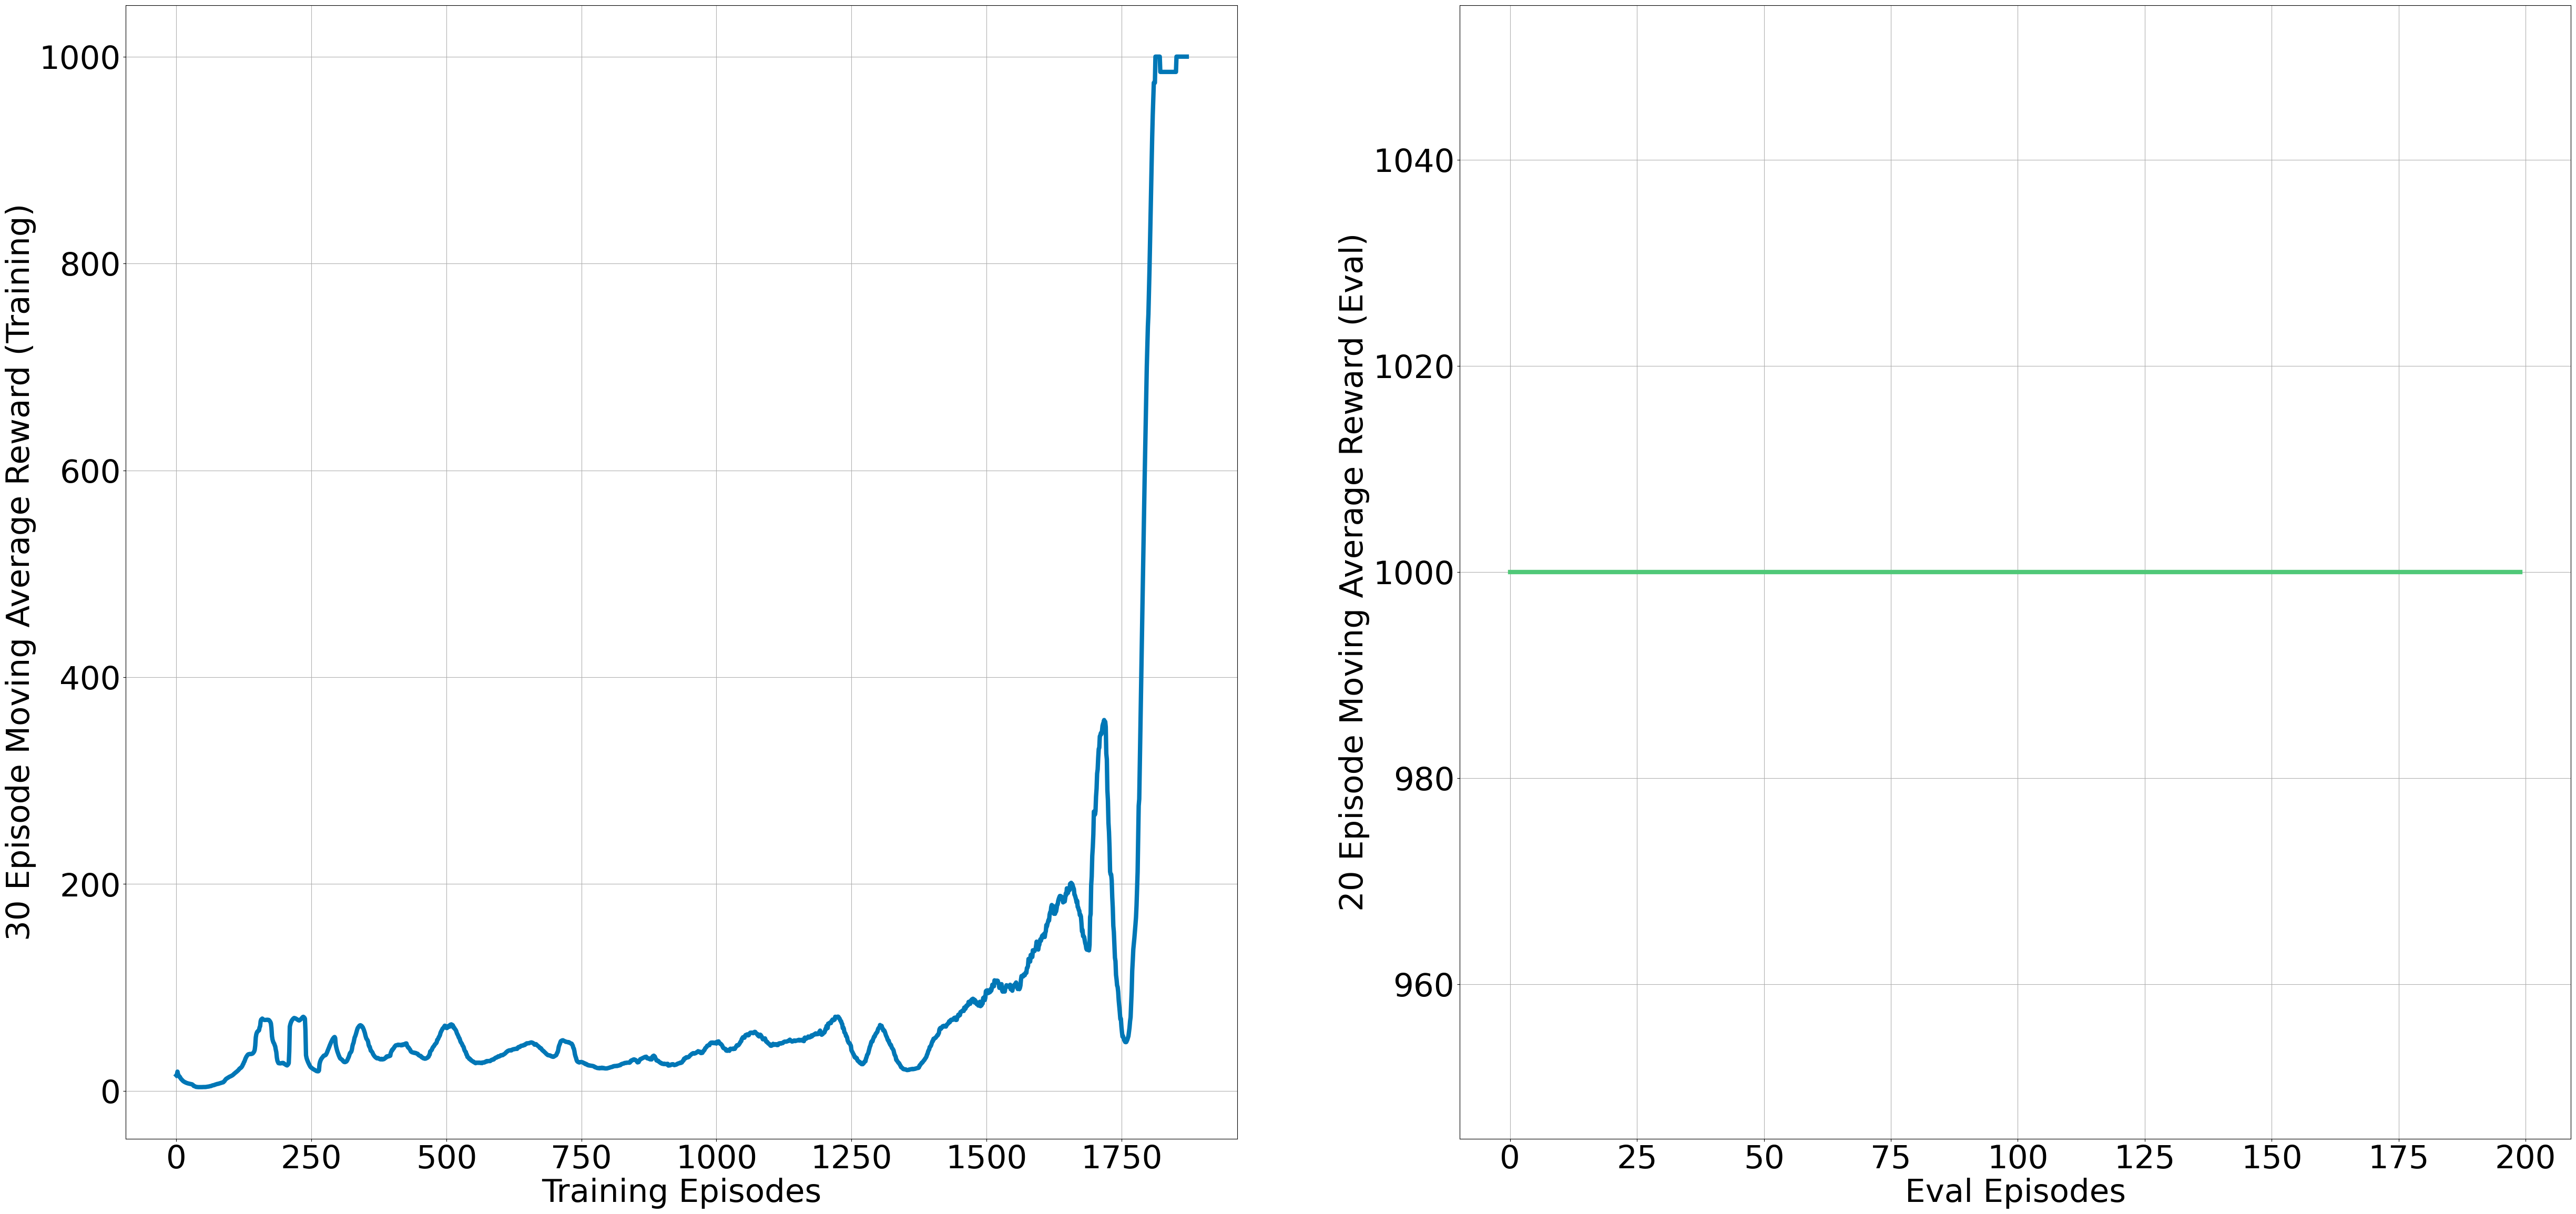

In [22]:
plot_metrics(avg_rwd, eval_avg_rwd, "30 Episode Moving Average Reward (Training)", "20 Episode Moving Average Reward (Eval)")